In [5]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio


In [6]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [7]:
# pip install seaborn

In [8]:
# pip install librosa

In [17]:
# Paths for data.
Ravdess = "archive/audio_speech_actors_01-24/"
Crema = "AudioWAV/"
Tess = "TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "ALL/"

1. Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12) - Female (as the actor ID number is even)

In [14]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    angry  archive/audio_speech_actors_01-24/Actor_16/03-...
1     fear  archive/audio_speech_actors_01-24/Actor_16/03-...
2     fear  archive/audio_speech_actors_01-24/Actor_16/03-...
3    angry  archive/audio_speech_actors_01-24/Actor_16/03-...
4  disgust  archive/audio_speech_actors_01-24/Actor_16/03-...

2. Crema DataFrame

In [15]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                          Path
0    angry  AudioWAV/1022_ITS_ANG_XX.wav
1    angry  AudioWAV/1037_ITS_ANG_XX.wav
2  neutral  AudioWAV/1060_ITS_NEU_XX.wav
3  neutral  AudioWAV/1075_ITS_NEU_XX.wav
4  disgust  AudioWAV/1073_IOM_DIS_XX.wav

3. TESS dataset

In [18]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  disgust  TESS Toronto emotional speech set data/TESS To...
1  disgust  TESS Toronto emotional speech set data/TESS To...
2  disgust  TESS Toronto emotional speech set data/TESS To...
3  disgust  TESS Toronto emotional speech set data/TESS To...
4  disgust  TESS Toronto emotional speech set data/TESS To...

4. CREMA-D dataset
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

In [19]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions             Path
0       sad  ALL/JK_sa01.wav
1       sad  ALL/JK_sa15.wav
2   neutral   ALL/DC_n13.wav
3  surprise  ALL/DC_su09.wav
4   neutral   ALL/DC_n07.wav

In [20]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0    angry  archive/audio_speech_actors_01-24/Actor_16/03-...
1     fear  archive/audio_speech_actors_01-24/Actor_16/03-...
2     fear  archive/audio_speech_actors_01-24/Actor_16/03-...
3    angry  archive/audio_speech_actors_01-24/Actor_16/03-...
4  disgust  archive/audio_speech_actors_01-24/Actor_16/03-...

## Data Visualisation and Exploration
First let's plot the count of each emotions in our dataset.

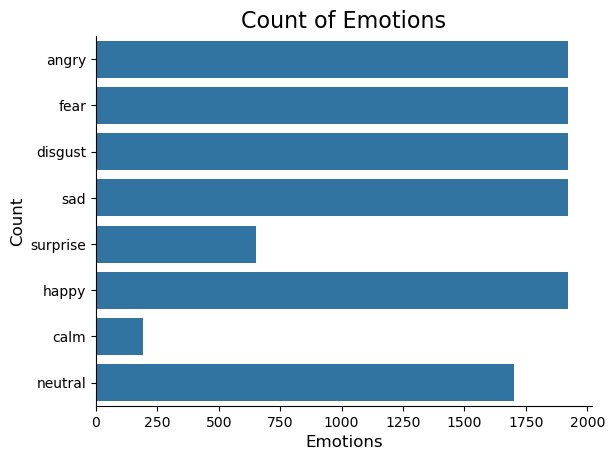

In [21]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

Waveplots - Waveplots let us know the loudness of the audio at a given time.
Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [27]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    # librosa.display.waveplot(data, sr=sr)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

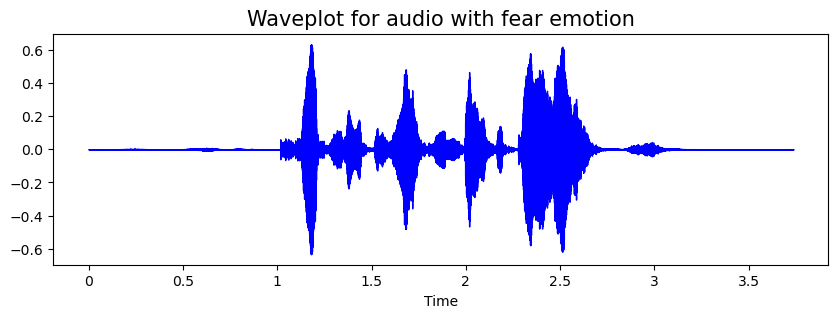

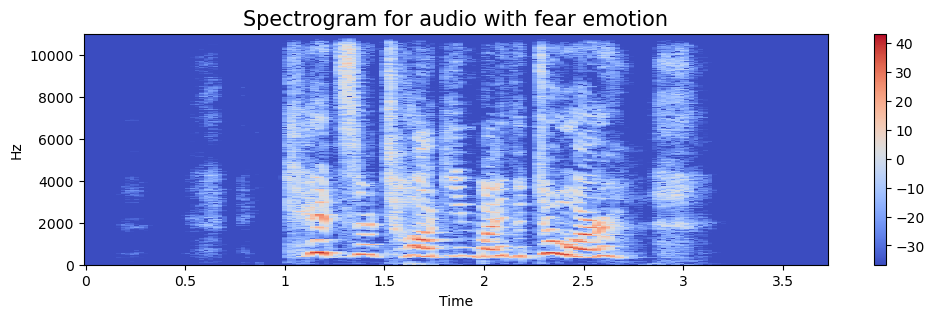

In [28]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

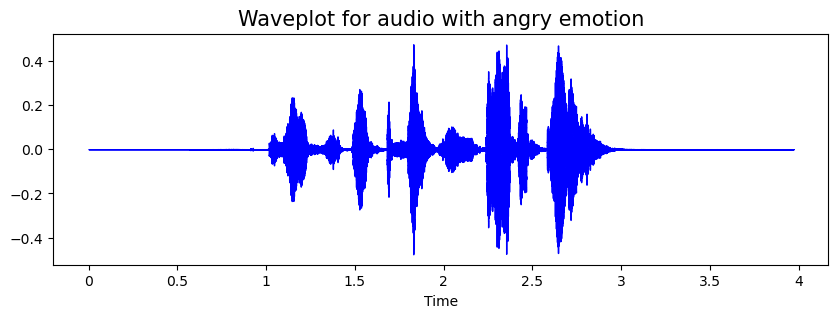

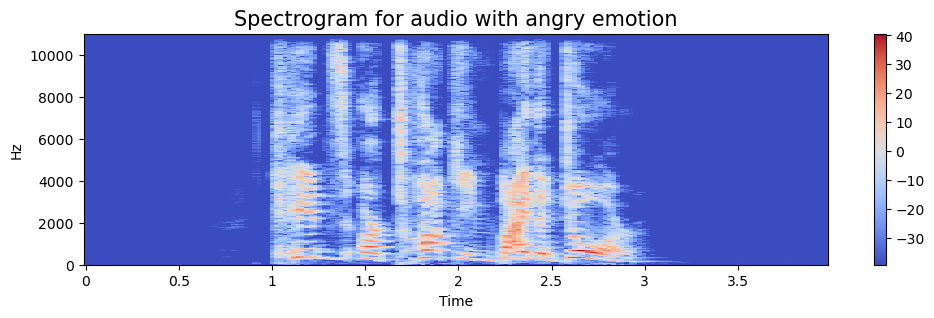

In [29]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

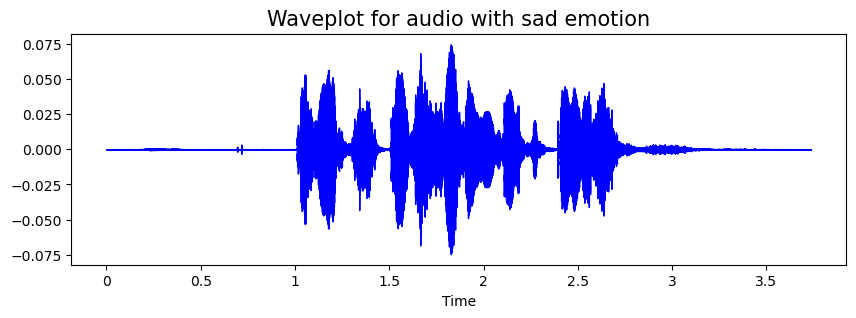

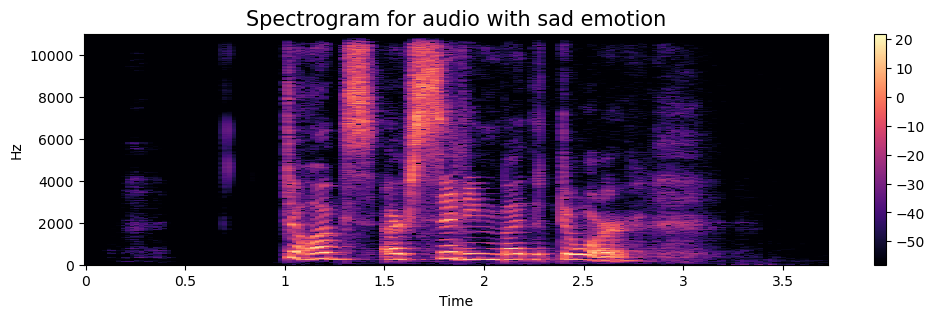

In [30]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

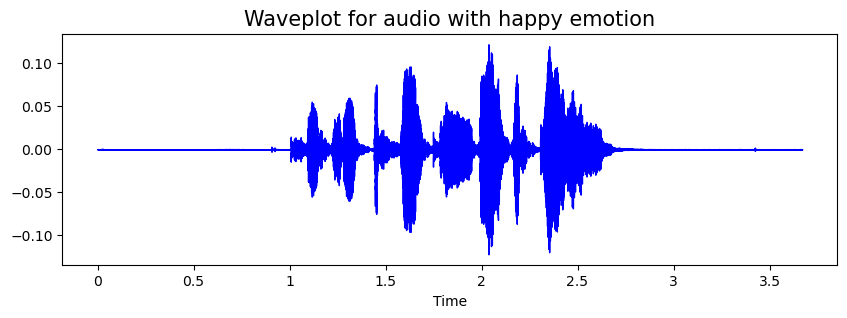

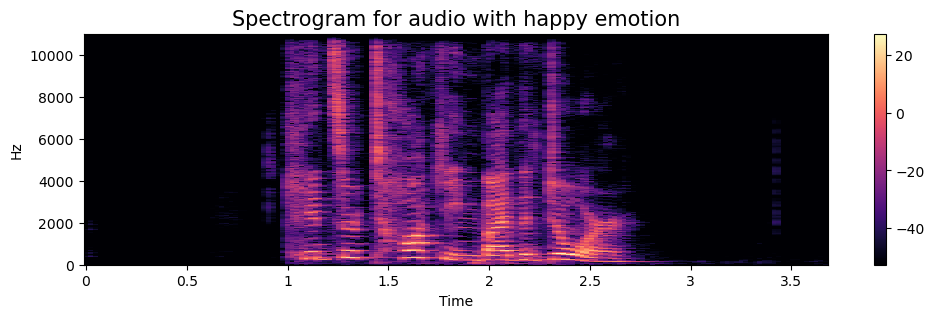

In [31]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [56]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    # return librosa.effects.time_stretch(data, rate=rate)
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    # return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

1. Simple Audio

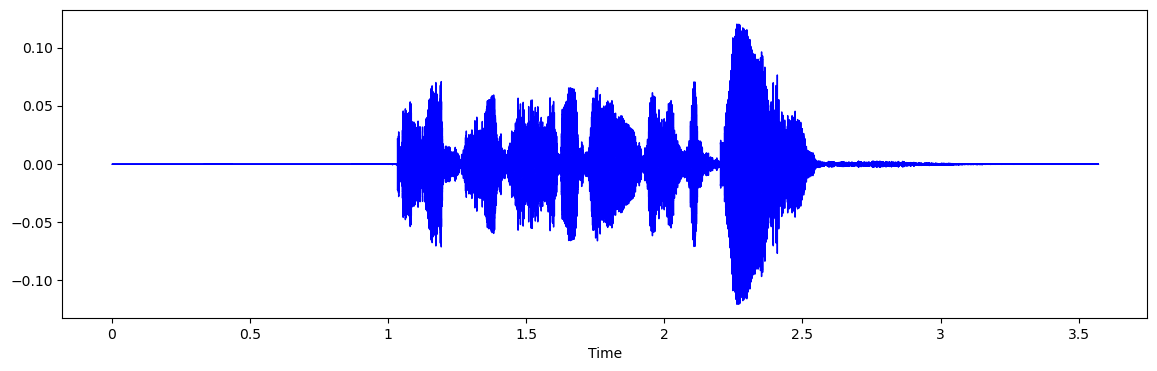

In [41]:
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=data, sr=sample_rate)
librosa.display.waveshow(y=data, sr=sample_rate, color="blue")
Audio(path)

2. Noise Injection

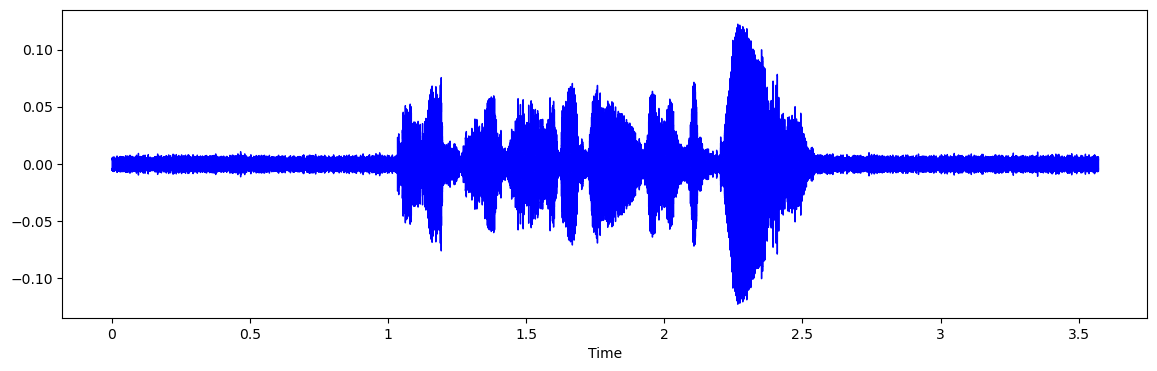

In [42]:
x = noise(data)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate, color="blue")
Audio(x, rate=sample_rate)

3. Stretching

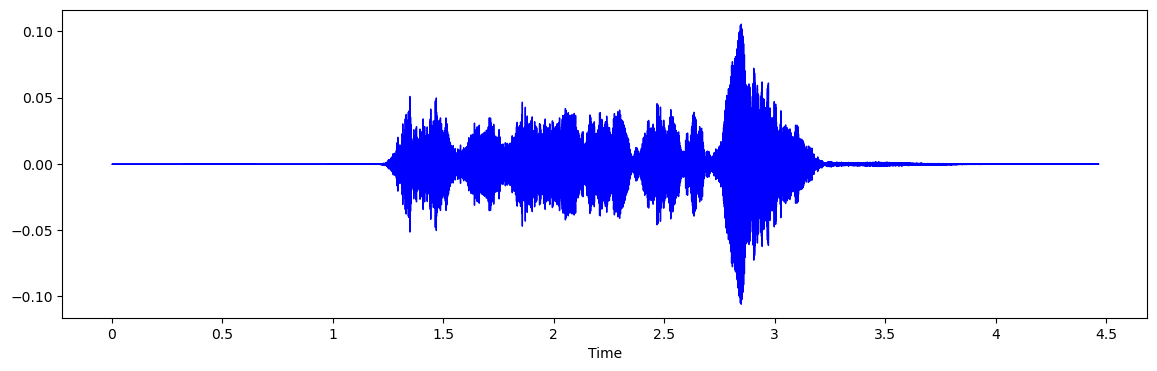

In [46]:
x = stretch(data)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate, color="blue")
Audio(x, rate=sample_rate)

4. Shifting

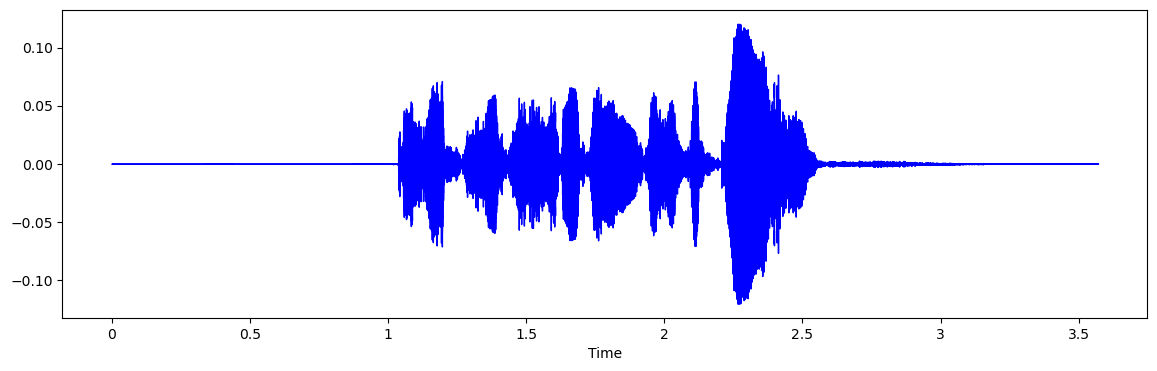

In [48]:
x = shift(data)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate, color="blue")
Audio(x, rate=sample_rate)

5. Pitch

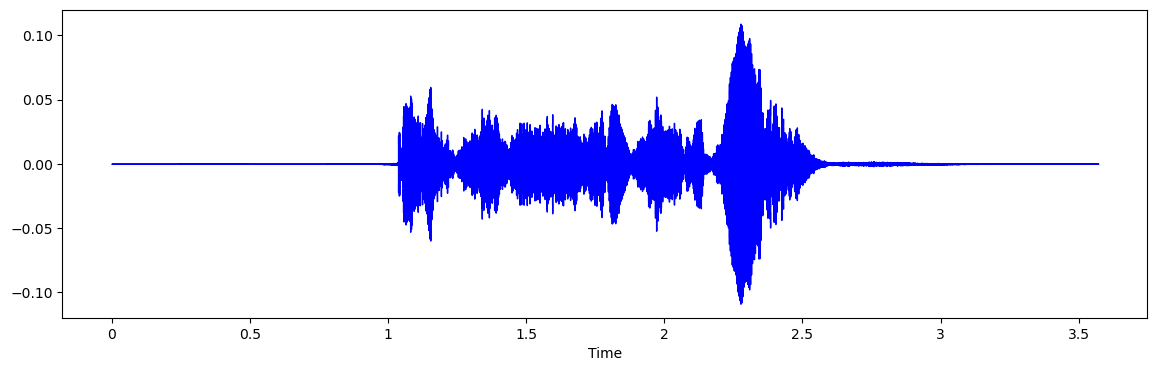

In [59]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
librosa.display.waveshow(y=x, sr=sample_rate, color='blue')
Audio(x, rate=sample_rate)

Feature Extraction

In [60]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [61]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [62]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [63]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.204540  0.519947  0.470245  0.491603  0.560526  0.548730  0.611754   
1  0.344799  0.674269  0.660410  0.691331  0.725336  0.701217  0.703742   
2  0.219394  0.621703  0.513836  0.481736  0.510988  0.545469  0.526372   
3  0.189815  0.559461  0.520419  0.483768  0.438286  0.392830  0.401268   
4  0.274871  0.703279  0.696471  0.678610  0.650219  0.602942  0.573285   

          7         8         9  ...       153       154       155       156  \
0  0.547266  0.531048  0.607427  ...  0.006682  0.004037  0.004855  0.004624   
1  0.625356  0.632319  0.692394  ...  0.009337  0.007290  0.007826  0.007514   
2  0.618308  0.529216  0.547129  ...  0.002832  0.002159  0.000685  0.000889   
3  0.409625  0.440601  0.506418  ...  0.002601  0.002952  0.003851  0.003154   
4  0.532349  0.543207  0.580820  ...  0.002656  0.002969  0.003869  0.003188   

        157       158       159       160       161  labels  
0  0.005723  0.006007  0.006103  0.005150  0.000251   angry  
1  0.008432  0.008724  0.008796  0.007728  0.003059   angry  
2  0.001203  0.001050  0.001300  0.000628  0.000051   angry  
3  0.002964  0.002586  0.002761  0.001653  0.000115    fear  
4  0.002999  0.002608  0.002786  0.001679  0.000147    fear  

[5 rows x 163 columns]

## Data Preparation

In [70]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [71]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [72]:
len(X)

36486

In [73]:
len(Y)

36486

In [74]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [75]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [76]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modeling

In [77]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

2023-11-22 14:54:23.258834: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-22 14:54:23.258877: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-22 14:54:23.258890: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-22 14:54:23.258980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-22 14:54:23.259038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [78]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2023-11-22 14:55:05.599995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


428/428 [==============================] - 44s 87ms/step - loss: 2.0216 - accuracy: 0.2786 - val_loss: 1.5677 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 33s 77ms/step - loss: 2.1608 - accuracy: 0.3438 - val_loss: 1.6800 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 33s 78ms/step - loss: 1.9902 - accuracy: 0.3635 - val_loss: 1.4607 - val_accuracy: 0.4335 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 34s 79ms/step - loss: 1.7303 - accuracy: 0.3836 - val_loss: 1.4293 - val_accuracy: 0.4419 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 34s 79ms/step - loss: 1.7927 - accuracy: 0.3810 - val_loss: 1.4789 - val_accuracy: 0.4438 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 33s 77ms/step - loss: 1.6910 - accuracy: 0.3927 - val_loss: 1.4777 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 34s 80ms/step -

286/286 [==============================] - 15s 49ms/step - loss: 1.2669 - accuracy: 0.4980
Accuracy of our model on test data :  49.80267584323883 %


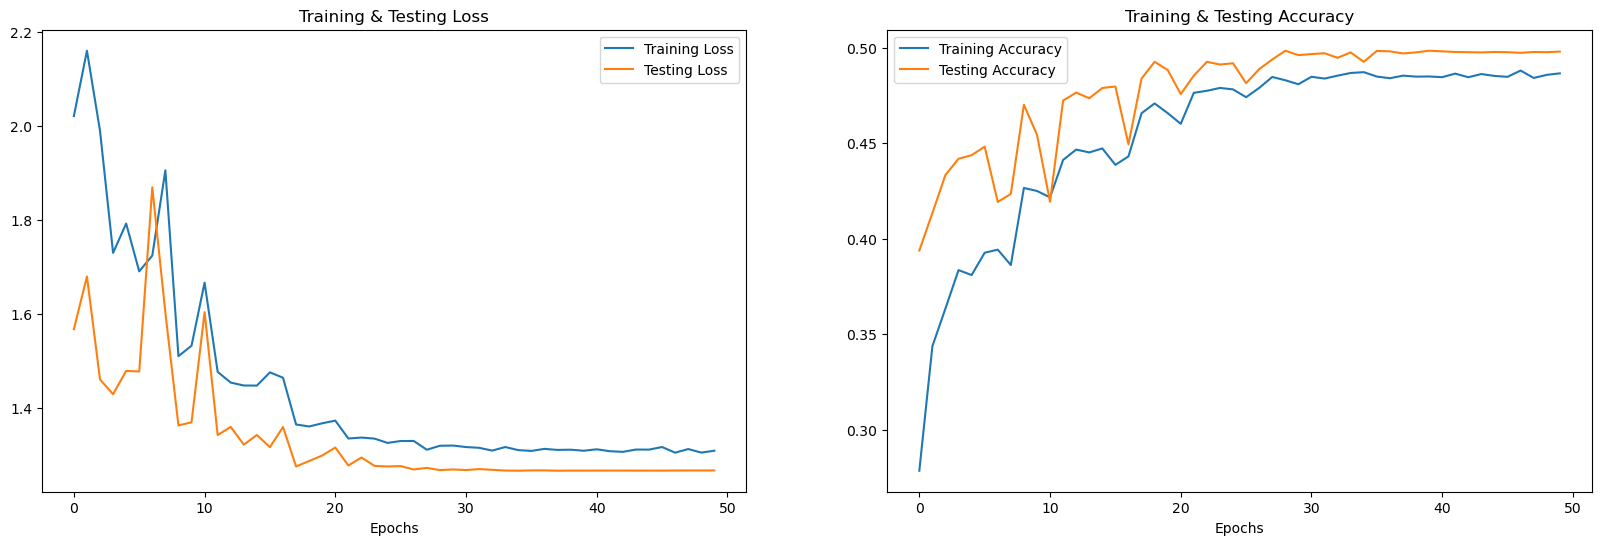

In [79]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [80]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 3s 9ms/step


In [81]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0            angry         angry
1         surprise      surprise
2          disgust       disgust
3            angry         angry
4              sad           sad
5            angry         happy
6             calm          calm
7              sad           sad
8              sad           sad
9          disgust      surprise

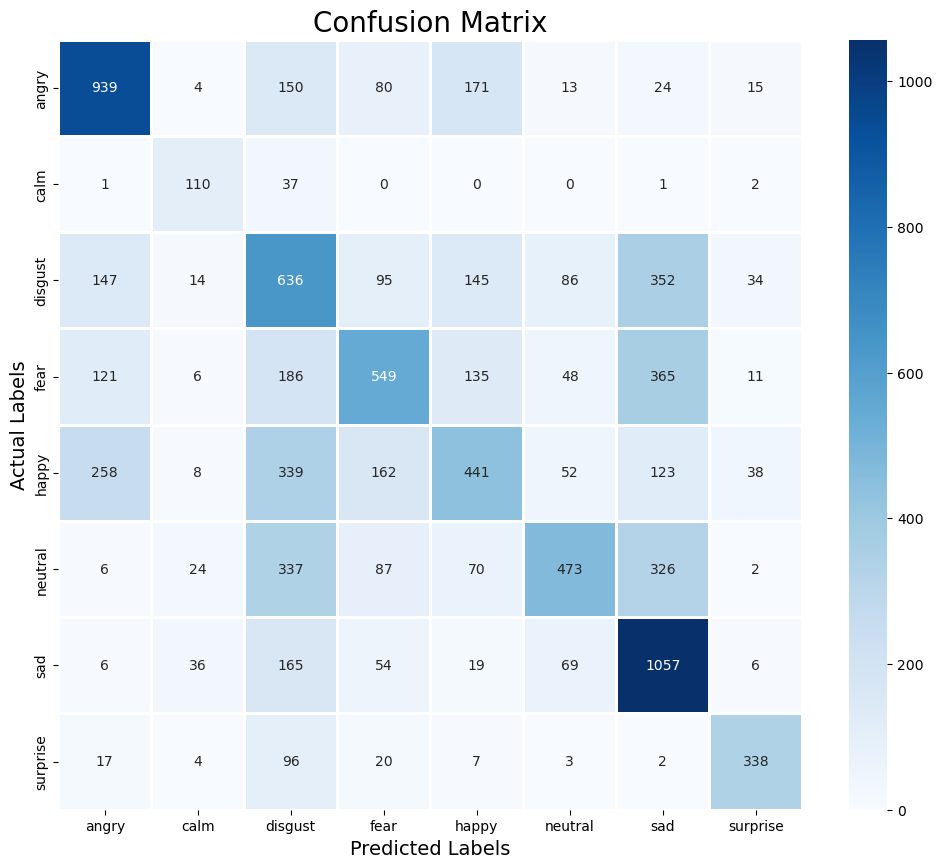

In [82]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.67      0.65      1396
        calm       0.53      0.73      0.62       151
     disgust       0.33      0.42      0.37      1509
        fear       0.52      0.39      0.44      1421
       happy       0.45      0.31      0.37      1421
     neutral       0.64      0.36      0.46      1325
         sad       0.47      0.75      0.58      1412
    surprise       0.76      0.69      0.72       487

    accuracy                           0.50      9122
   macro avg       0.54      0.54      0.53      9122
weighted avg       0.52      0.50      0.49      9122

